In [12]:
import matplotlib.font_manager as font_manager
import alphashape
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
from shapely.geometry import Polygon
import osmnx as osmnx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

resultpath = 'results/'
network_polygon = '../../data/network/QGIS_Project/referentiel-comptages-edit.shp'

cycleways = gpd.read_file('../../data/cycleways_2000-2022.geojson')
plan_velo_2026 = gpd.read_file('../../data/plan-velo-2026.geojson')
paris_districts = gpd.read_file('../../data/districts_paris.geojson')

polygon_all_districts = paris_districts.unary_union

def get_exterior_coords(df, start_point, end_point):
    filtered_gdf = df[(df["c_ar"] >= start_point) & (df["c_ar"] <= end_point)]

    # Check if there are any polygons matching the condition
    if not filtered_gdf.empty:
        # Apply unary_union to combine the selected polygons into a single polygon
        districts_polygon = unary_union(filtered_gdf["geometry"])
    else:
        # If no polygons match the condition, union_polygon will be None
        districts_polygon = None

    return districts_polygon.exterior.coords.xy

In [13]:
# cycleways_red = cycleways[cycleways['typologie_simple'] == 'Pistes cyclables']
cycleways_2010_2023 = cycleways[cycleways['date_de_livraison'] >= "2010-01-01"]
cycleways_2010_2023_red = cycleways_2010_2023[cycleways_2010_2023['typologie_simple'] == 'Pistes cyclables']

In [14]:
qgis_road_network = gpd.read_file(network_polygon)
qgis_road_network.crs = "EPSG:4326"
alpha_shape = alphashape.alphashape(qgis_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

In [15]:
# get OSM dataframe

ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon_all_districts, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

ox.settings.log_console = True
G_bike_network = ox.graph_from_polygon(
    polygon_all_districts, simplify=True, network_type="bike")
nodes_osm, df_osm_bike = momepy.nx_to_gdf(G_bike_network, points=True, lines=True)
df_osm_bike['osm_id'] = range(1, len(df_osm_bike) + 1)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_29050/923663547.py:6: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_29050/923663547.py:12: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm_bike = momepy.nx_to_gdf(G_bike_network, points=True, lines=True)


In [16]:
x_district_1_4, y_district_1_4  = get_exterior_coords(paris_districts, 1, 4)
x_district_5_7, y_district_5_7  = get_exterior_coords(paris_districts, 5, 7)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_29050/1430789950.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):


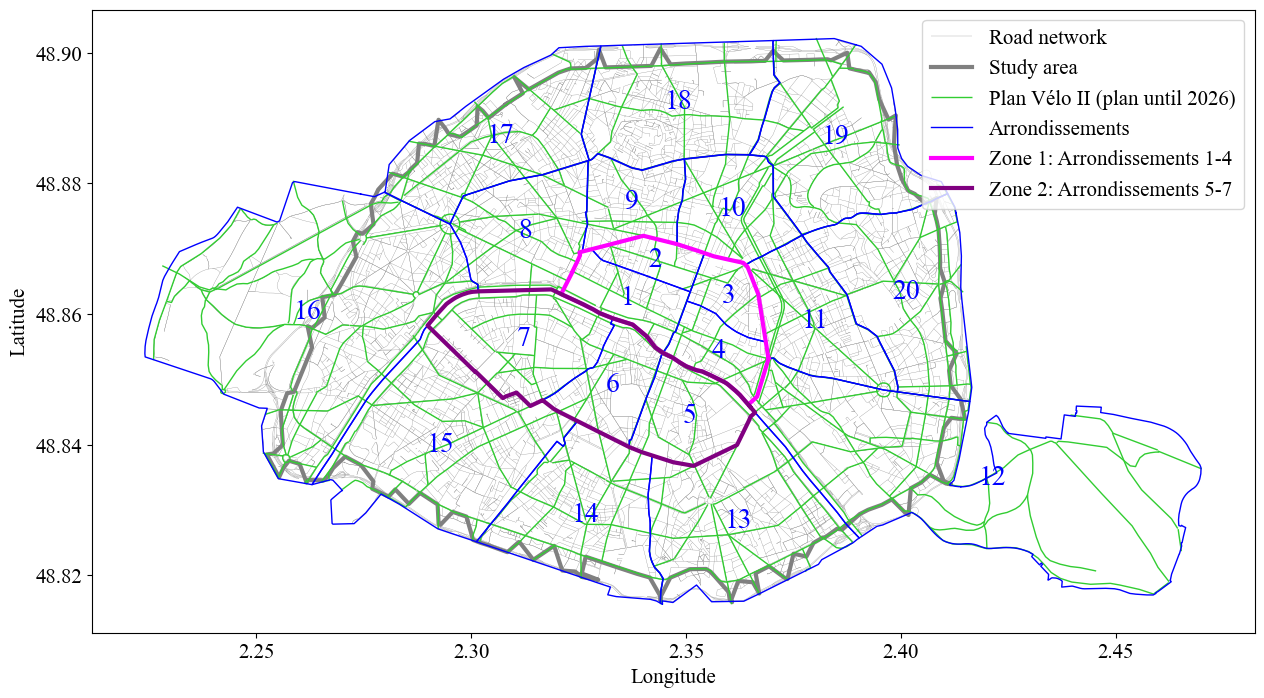

In [17]:
fig, ax = plt.subplots(figsize=figsize)
# ax.set_title('Paris\' Arrondissements with Plan Velo II', font = font, fontsize = fontsize)

# df_osm_bike.plot(ax = ax, color = "grey", linewidth = 0.2, label = 'Network')
light_green_rgb = (144, 238, 144)
# paris_districts.plot(column='c_ar', ax=ax, legend=False, alpha = 0.1, edgecolor='black', linewidth = 5)
df_osm.plot(ax = ax, color = "grey", linewidth = 0.2, label = "Road network")
ax.plot(x_coords, y_coords, color='grey', linewidth=3, label='Study area')
plan_velo_2026.plot(ax = ax, color =(50/255, 205/255, 50/255), linewidth = 1, label = "Plan Vélo II (plan until 2026)")

detectors = gpd.read_file('../../data/all_car_detectors.geojson')


# cycleways_2010_2023.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")
for idx, row in paris_districts.iterrows():
    # Plot each polygon
    x, y = row['geometry'].exterior.xy
    if idx == 0:
        plt.plot(x, y, color = "blue", linewidth = 1, label = 'Arrondissements')
    else: 
        plt.plot(x, y, color = "blue", linewidth = 1)

plt.plot(x_district_1_4, y_district_1_4, color = 'magenta', linewidth = 3, label = 'Zone 1: Arrondissements 1-4')
plt.plot(x_district_5_7, y_district_5_7, color = 'purple', linewidth = 3, label = 'Zone 2: Arrondissements 5-7')

for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):
    ax.text(x, y, label, color = 'blue', fontsize=fontsize, font = font, ha='center', va='center') 
plt.xticks(font = font, fontsize = 15)
plt.yticks(font = font, fontsize = 15)
plt.xlabel("Longitude", font = font, fontsize = 15)
plt.ylabel("Latitude", font = font, fontsize = 15)
font_legend = font_manager.FontProperties(family=font, style='normal', size=15)
plt.legend(loc='upper right', prop = font_legend)
plt.savefig(resultpath + 'paris_districts.png', dpi = 200, bbox_inches = 'tight')